## Load Libraries Needed

In [1]:
!pip install pmdarima

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
import numpy as np
import pandas as pd
from datetime import datetime
import re
import nltk
from sklearn.feature_extraction import text
from textblob import TextBlob
from nltk.sentiment.vader import SentimentIntensityAnalyzer
nltk.download('vader_lexicon')
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.svm import SVR
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from pmdarima import auto_arima

[nltk_data] Downloading package vader_lexicon to /root/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


## Part1: Sentimental Analysis on Textual Data

## Read Textual Data

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [4]:
indian_news = pd.read_csv('drive/MyDrive/india-news-headlines.csv')
# shape of the data
indian_news.shape

(3650970, 3)

## Explore the Textual Data

In [5]:
indian_news.head(15)

,publish_date,headline_category,headline_text
0,20010102,unknown,Status quo will not be disturbed at Ayodhya; s...
1,20010102,unknown,Fissures in Hurriyat over Pak visit
2,20010102,unknown,America's unwanted heading for India?
3,20010102,unknown,For bigwigs; it is destination Goa
4,20010102,unknown,Extra buses to clear tourist traffic
5,20010102,unknown,Dilute the power of transfers; says Riberio
6,20010102,unknown,Focus shifts to teaching of Hindi
7,20010102,unknown,IT will become compulsory in schools
8,20010102,unknown,Move to stop freedom fighters' pension flayed
9,20010102,unknown,Gilani claims he applied for passport 2 years ago


In [6]:
indian_news.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3650970 entries, 0 to 3650969
Data columns (total 3 columns):
 #   Column             Dtype 
---  ------             ----- 
 0   publish_date       int64 
 1   headline_category  object
 2   headline_text      object
dtypes: int64(1), object(2)
memory usage: 83.6+ MB


## Preprocessing for the Indian News Headlines Data

In [7]:
# Delete unnecessary column
indian_news.drop(columns=['headline_category'],inplace=True)

In [8]:
# convert the publish_data column to datetime datatype
indian_news['publish_date'] = indian_news['publish_date'].map(lambda x : str(x))
indian_news['publish_date'] = indian_news['publish_date'].map(lambda x : datetime.strptime(x,'%Y%m%d'))

In [9]:
# grouping headlines of each day
indian_news['headline_text'] = indian_news.groupby(['publish_date']).transform(lambda x : ' '.join(x))
# drop duplicates in each row
indian_news.drop_duplicates(inplace=True)
# reset index
indian_news.reset_index(inplace=True,drop=True)

In [10]:
# convert headline text to lowercase
indian_news['headline_text'] = indian_news['headline_text'].map(lambda x : x.lower())
# remove all special characters 
indian_news['headline_text'] = indian_news['headline_text'].map(lambda x : re.sub("[^a-zA-Z']",' ',x))
# load english stopwords
stopwords = text.ENGLISH_STOP_WORDS
# remove english stopwords
indian_news['headline_text'] = indian_news['headline_text'].map(lambda x : [word for word in x.split() if word not in stopwords])
# convert the output list above into a string
indian_news['headline_text'] = indian_news['headline_text'].map(lambda x : " ".join(x))

In [11]:
# explore the textual data after preprocessing
indian_news.head(15)

,publish_date,headline_text
0,2001-01-02,status quo disturbed ayodhya says vajpayee fis...
1,2001-01-03,powerless north india gropes dark think laxman...
2,2001-01-04,string pulled stephen hawking india vajpayee g...
3,2001-01-05,light combat craft takes india club class hawk...
4,2001-01-06,light combat craft takes india club class hawk...
5,2001-01-07,muslim body rules talks ayodhya bajrang dal bl...
6,2001-01-08,sangh parivar babri panel ante frontrunner key...
7,2001-01-09,financier bharat shah held alleged links chott...
8,2001-01-10,fend pande tells doctors bureaucracy undermini...
9,2001-01-23,sonia takes hindutva brigade congress hopes so...


In [12]:
print('Shape of Data after Preprocessing is:',indian_news.shape)

Shape of Data after Preprocessing is: (7717, 2)


## Determine Headline Text's Polarirty and Subjectivity

In [13]:
# polarity
indian_news['polarity'] = indian_news['headline_text'].map(lambda x : TextBlob(x).sentiment.polarity)
# subjectivity
indian_news['subjectivity'] = indian_news['headline_text'].map(lambda x : TextBlob(x).sentiment.subjectivity)

## Apply Sentiment Analysis on Headlines Text

In [14]:
sentiment_analyzer = SentimentIntensityAnalyzer()
# compound sentiment
indian_news['compound'] = indian_news['headline_text'].map(lambda x : sentiment_analyzer.polarity_scores(x)['compound'])
# positive sentiment
indian_news['positive'] = indian_news['headline_text'].map(lambda x : sentiment_analyzer.polarity_scores(x)['pos'])
# negative sentiment
indian_news['negative'] = indian_news['headline_text'].map(lambda x : sentiment_analyzer.polarity_scores(x)['neg'])
# neutral sentiment
indian_news['neutral'] = indian_news['headline_text'].map(lambda x : sentiment_analyzer.polarity_scores(x)['neu'])

In [15]:
# explore the textual data after determining polarity and subjectivity and apply sentiment analysis
indian_news

,publish_date,headline_text,polarity,subjectivity,compound,positive,negative,neutral
0,2001-01-02,status quo disturbed ayodhya says vajpayee fis...,0.130159,0.259921,-0.9662,0.105,0.170,0.726
1,2001-01-03,powerless north india gropes dark think laxman...,0.111538,0.415385,-0.1280,0.147,0.154,0.698
2,2001-01-04,string pulled stephen hawking india vajpayee g...,0.074312,0.431387,0.4019,0.129,0.132,0.739
3,2001-01-05,light combat craft takes india club class hawk...,0.258827,0.505995,0.8300,0.182,0.176,0.641
4,2001-01-06,light combat craft takes india club class hawk...,0.176623,0.422078,-0.8860,0.105,0.240,0.655
...,...,...,...,...,...,...,...,...
7712,2022-03-27,playing dead man body god meant sitting refrig...,0.023741,0.367097,-0.9998,0.090,0.165,0.745
7713,2022-03-28,fashion democratic demand stylists soars 'the ...,0.053706,0.387789,-0.9996,0.106,0.154,0.740
7714,2022-03-29,bobby deol like dad hope working age yashas su...,0.074313,0.404815,-0.9997,0.092,0.150,0.758
7715,2022-03-30,trends dossmode time gave boyfriend incredible...,0.020873,0.346238,-0.9998,0.089,0.161,0.749


## Part2: Numerical Analysis of Historical Stock Prices

## Read Numerical Data

In [16]:
stock_prices = pd.read_csv('drive/MyDrive/^IXIC.csv')
stock_prices.shape

(5345, 7)

In [17]:
stock_prices.head(15)

,Date,Open,High,Low,Close,Adj Close,Volume
0,02/01/2001,2474.159912,2474.159912,2273.070068,2291.860107,2291.860107,1918930000
1,03/01/2001,2254.560059,2618.030029,2251.709961,2616.689941,2616.689941,3188000000
2,04/01/2001,2593.959961,2644.800049,2549.830078,2566.830078,2566.830078,2610680000
3,05/01/2001,2573.110107,2574.620117,2395.389893,2407.649902,2407.649902,2104670000
4,08/01/2001,2388.719971,2397.060059,2299.649902,2395.919922,2395.919922,1850590000
5,09/01/2001,2424.689941,2474.159912,2406.080078,2441.300049,2441.300049,1975130000
6,10/01/2001,2392.709961,2525.280029,2376.489990,2524.179932,2524.179932,2470350000
7,11/01/2001,2495.590088,2661.929932,2495.010010,2640.570068,2640.570068,2842640000
8,12/01/2001,2639.560059,2699.870117,2589.629883,2626.500000,2626.500000,2518850000
9,16/01/2001,2631.489990,2638.219971,2576.949951,2618.550049,2618.550049,2073940000


In [18]:
stock_prices.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5345 entries, 0 to 5344
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Date       5345 non-null   object 
 1   Open       5345 non-null   float64
 2   High       5345 non-null   float64
 3   Low        5345 non-null   float64
 4   Close      5345 non-null   float64
 5   Adj Close  5345 non-null   float64
 6   Volume     5345 non-null   int64  
dtypes: float64(5), int64(1), object(1)
memory usage: 292.4+ KB


## Preprocessing for Historical Stock Prices Data

In [19]:
# convert the date format to match the date format in the textual data
stock_prices['Date'] = stock_prices['Date'].map(lambda x : datetime.strptime(x,'%d/%m/%Y').strftime('%Y-%m-%d')).astype('datetime64[ns]')

## Apply Statistical Models on the Historical Stock Prices Data

In [20]:
# time axis
time = np.arange(len(stock_prices['Close']))

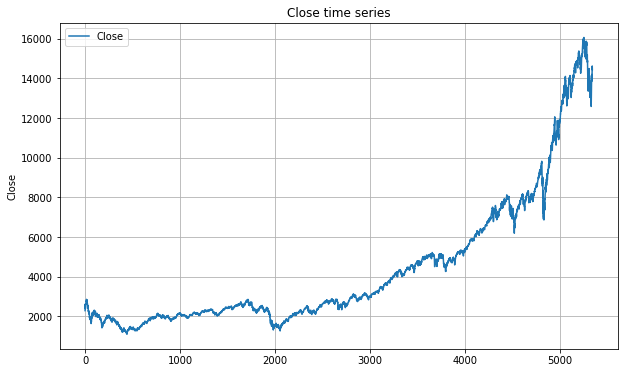

In [21]:
plt.figure(figsize=(10,6))
plt.title('Close time series')
stock_prices['Close'].plot()
plt.ylabel('Close')
plt.grid()
plt.legend()

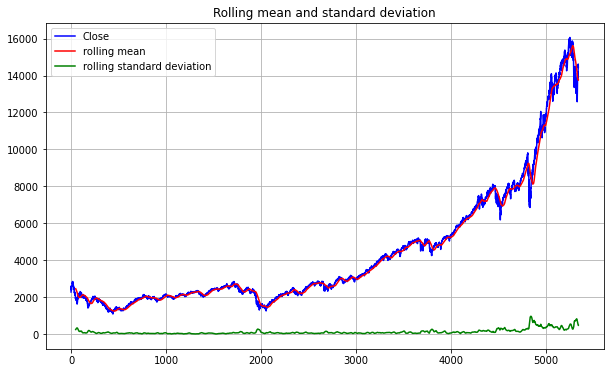

In [22]:
# plot moving average
rolling_mean = stock_prices['Close'].rolling(window=50).mean() 
rolling_std = stock_prices['Close'].rolling(window=50).std()
# plotting...
plt.figure(figsize=(10,6))
plt.title('Rolling mean and standard deviation')
stock_prices['Close'].plot(color='blue',label='Close')
plt.plot(time,rolling_mean,color='red',label='rolling mean')
plt.plot(time,rolling_std,color='green',label='rolling standard deviation')
plt.grid()
plt.legend()

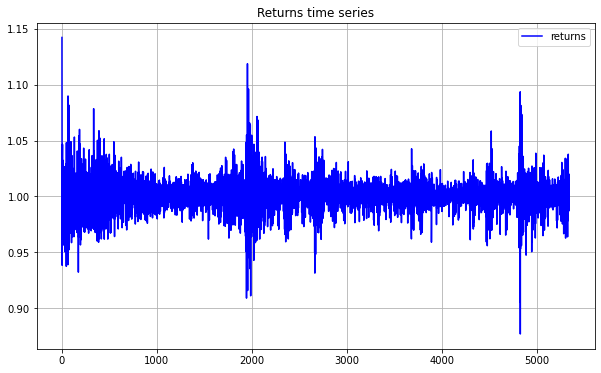

In [23]:
# plot returns
returns = stock_prices['Close'] / (stock_prices['Close'].shift(1) - 1)
# plotting...
plt.figure(figsize=(10,6))
plt.title('Returns time series')
plt.plot(time,returns,color='blue',label='returns')
plt.grid()
plt.legend()

In [24]:
# split quantity
SPLIT = 4276

In [25]:
# split the data into training and testing sets
train = stock_prices[:SPLIT]
test = stock_prices[SPLIT:]

In [26]:
# time axis train
time_train = np.arange(len(train.Close))
# time axis test
time_test = np.arange(len(test.Close))

In [27]:
# stationary test
def stationary_test(series):
  time_x = np.arange(len(series))
  mean = series.rolling(window=50).mean() 
  std = series.rolling(window=50).std()
  plt.figure(figsize=(10,6))
  plt.title('Rolling mean and standard deviation')
  series.plot(color='blue',label='Close')
  plt.plot(time_x,mean,color='red',label='rolling mean')
  plt.plot(time_x,std,color='green',label='rolling standard deviation')
  plt.grid()
  plt.legend()

  print('Results of dickey fuller test')
  result = adfuller(series, autolag = 'AIC')
  labels = ['ADF Test Statistic','p-value','#Lags Used','Number of Observations Used']
  for value , label in zip(result,labels):
    print(label, ':' , value)
  if result[1] <= 0.05:
    print("Strong evidence against the null hypothesis(Ho), reject the null hypothesis. Data is stationary")
  else:
    print("Weak evidence against null hypothesis, time series is non-stationary ")

Results of dickey fuller test
ADF Test Statistic : 1.7932084952085314
p-value : 0.99833545164189
#Lags Used : 2
Number of Observations Used : 4273
Weak evidence against null hypothesis, time series is non-stationary 


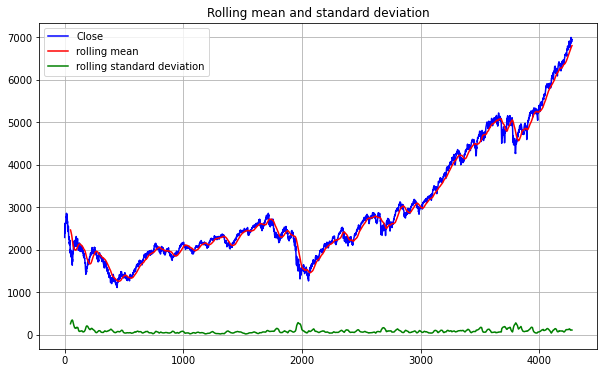

In [28]:
stationary_test(train.Close)

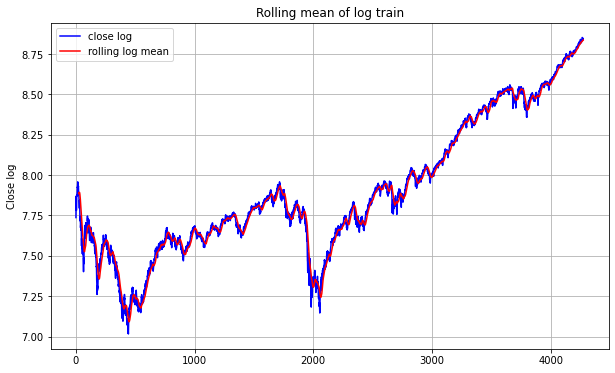

In [29]:
# log
train_log = np.log(train['Close'])
test_log = np.log(test['Close'])

rolling_log_mean = train_log.rolling(24).mean()
plt.figure(figsize=(10,6))
plt.title('Rolling mean of log train')
plt.ylabel('Close log')
plt.plot(time_train,train_log,color='blue',label='close log')
plt.plot(time_train,rolling_log_mean,color='red',label='rolling log mean')
plt.grid()
plt.legend()

Results of dickey fuller test
ADF Test Statistic : 0.15754737060724225
p-value : 0.9697774809553974
#Lags Used : 19
Number of Observations Used : 4256
Weak evidence against null hypothesis, time series is non-stationary 


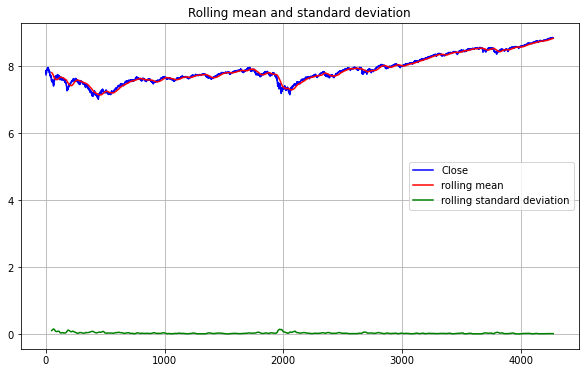

In [30]:
stationary_test(train_log)

Results of dickey fuller test
ADF Test Statistic : -10.00658709443466
p-value : 1.8246663152584574e-17
#Lags Used : 23
Number of Observations Used : 4229
Strong evidence against the null hypothesis(Ho), reject the null hypothesis. Data is stationary


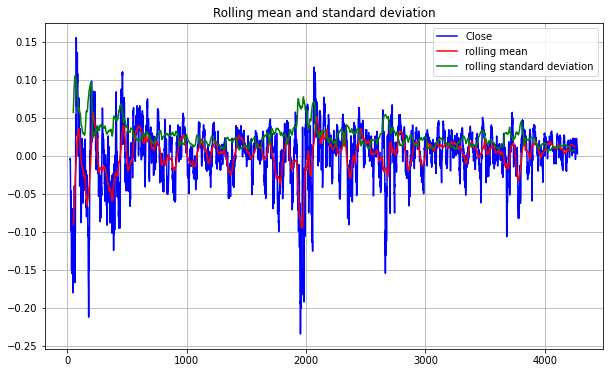

In [31]:
train_log_diff = train_log - rolling_log_mean
train_log_diff.dropna(inplace=True)
# apply the sationary test
stationary_test(train_log_diff)

In [32]:
model = auto_arima(train_log, trace=True,error_action='ignore',suppress_warnings=True)
model.fit(train_log)
preds = model.predict(n_periods=len(test))
preds_df = pd.DataFrame(preds,index=test_log.index,columns=['predictions'])

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=-24003.685, Time=3.30 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-23990.498, Time=0.69 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-23993.381, Time=0.49 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-23993.960, Time=0.88 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-23991.167, Time=0.18 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=-24005.521, Time=5.57 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=-24006.656, Time=2.03 sec
 ARIMA(0,1,3)(0,0,0)[0] intercept   : AIC=-24005.060, Time=1.81 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-23994.928, Time=1.08 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=-24003.010, Time=1.45 sec
 ARIMA(0,1,2)(0,0,0)[0]             : AIC=-24007.057, Time=1.61 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=-23994.533, Time=0.27 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=-24005.530, Time=0.41 sec
 ARIMA(0,1,3)(0,0,0)[0]             : AIC=-24005.501, Time=0.46 sec
 ARIM

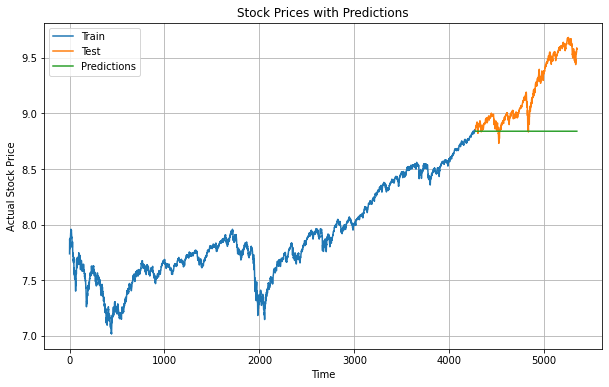

In [44]:
plt.figure(figsize=(10,6))
plt.title('Stock Prices with Predictions')
plt.plot(train_log,label='Train')
plt.plot(test_log,label='Test')
plt.plot(preds_df,label='Predictions')
plt.ylabel('Actual Stock Price')
plt.xlabel('Time')
plt.grid()
plt.legend()

In [47]:
# calculating error
rmse = np.sqrt(mean_squared_error(test_log,preds_df))
print('RMSE:',rmse)

RMSE: 0.4490829135765086


## Part3: Hybrid Model using Textual Data with Numerical Data

## Merge Textual and Numerical Data

In [48]:
indian_news = indian_news.rename(columns={'publish_date':'Date'})
Data = pd.merge(stock_prices,indian_news,how='inner',on='Date')

In [49]:
# drop unnecessary columns
Data.drop(columns=['Date','headline_text','Volume','Open','High','Low','Adj Close'],inplace=True)
print('Shape of the Data is:',Data.shape)
print(Data.columns)

Shape of the Data is: (5317, 7)
Index(['Close', 'polarity', 'subjectivity', 'compound', 'positive', 'negative',
       'neutral'],
      dtype='object')


In [50]:
Data

,Close,polarity,subjectivity,compound,positive,negative,neutral
0,2291.860107,0.130159,0.259921,-0.9662,0.105,0.170,0.726
1,2616.689941,0.111538,0.415385,-0.1280,0.147,0.154,0.698
2,2566.830078,0.074312,0.431387,0.4019,0.129,0.132,0.739
3,2407.649902,0.258827,0.505995,0.8300,0.182,0.176,0.641
4,2395.919922,-0.033519,0.415078,-0.9709,0.093,0.156,0.751
...,...,...,...,...,...,...,...
5312,14191.839840,0.025311,0.371786,-0.9999,0.089,0.178,0.733
5313,14169.299810,-0.037316,0.374964,-0.9999,0.080,0.177,0.743
5314,14354.900390,0.053706,0.387789,-0.9996,0.106,0.154,0.740
5315,14619.639650,0.074313,0.404815,-0.9997,0.092,0.150,0.758


## Scale the Data to be ready to fed into the Machine Learning Algorithms

In [51]:
# scale the data
scaler = StandardScaler()
Data_scaled = scaler.fit_transform(Data)

# convert data into dataframe
Data_scaled_df = pd.DataFrame(Data_scaled,index=Data.index,columns=Data.columns)
Data_scaled_df

,Close,polarity,subjectivity,compound,positive,negative,neutral
0,-0.622009,1.966532,-3.773237,-0.185773,-0.503235,0.055229,0.391192
1,-0.527010,1.495465,0.228304,1.814160,1.194262,-0.607553,-0.511712
2,-0.541592,0.553686,0.640200,3.078494,0.466763,-1.518879,0.810397
3,-0.588145,5.221674,2.560549,4.099934,2.608842,0.303773,-2.349766
4,-0.591576,-2.174304,0.220410,-0.196987,-0.988234,-0.524705,1.197356
...,...,...,...,...,...,...,...
5312,2.858212,-0.685985,-0.893905,-0.266180,-1.149900,0.386620,0.616918
5313,2.851620,-2.270350,-0.812096,-0.266180,-1.513649,0.345196,0.939384
5314,2.905900,0.032390,-0.481988,-0.265465,-0.462818,-0.607553,0.842644
5315,2.983324,0.553712,-0.043739,-0.265703,-1.028650,-0.773249,1.423082


In [52]:
X = Data_scaled_df.drop(columns='Close')
y = Data_scaled_df[['Close']]

In [53]:
# split the data into train and test sets
X_train , X_test , y_train , y_test = train_test_split(X,y,test_size=0.2)

## Train Machine Learning Algorithms

In [54]:
# instantiate different machine learning algorithms

# decision tree
decision_tree_reg = DecisionTreeRegressor()
# linear regression
linear_regression = LinearRegression()
# svm
svm_reg = SVR()

In [55]:
# train decision tree
decision_tree_reg.fit(X_train,y_train)
print('training complete...')

training complete...


In [56]:
# train decision tree
linear_regression.fit(X_train,y_train)
print('training complete...')

training complete...


In [57]:
# train decision tree
svm_reg.fit(X_train,np.ravel(y_train))
print('training complete...')

training complete...


## Compute Accuracy for each Model's Predictions

In [58]:
def model_accuracy(model,X_test,y_test,label):
  predictions = model.predict(X_test)
  predictions_df = pd.DataFrame(predictions,index=y_test.index,columns=['predictions close'])
  mse = mean_squared_error(y_test,predictions_df)
  mae = mean_absolute_error(y_test,predictions_df)

  print('The',label,'has mean_squared_error:',mse)
  print('The',label,'has mean_absolute_error',mae)

  return mse,mae

In [59]:
# decision tree regressor
mse_decision_tree , mae_decision_tree = model_accuracy(decision_tree_reg,X_test,y_test,'DecisionTreeRegressor')

The DecisionTreeRegressor has mean_squared_error: 0.604833829439424
The DecisionTreeRegressor has mean_absolute_error 0.46338989848886514


In [60]:
# linear regression
mse_linear_regression , mae_linear_regression = model_accuracy(linear_regression,X_test,y_test,'LinearRegression')

The LinearRegression has mean_squared_error: 0.6623666246084257
The LinearRegression has mean_absolute_error 0.6033565975159629


In [61]:
# svm regressor
mse_svm_regressor , mae_svm_regressor = model_accuracy(svm_reg,X_test,y_test,'SVR')

The SVR has mean_squared_error: 0.4081423003530311
The SVR has mean_absolute_error 0.42799975229676457


## Visualize Performance of each Machine Learning Model

In [62]:
def plot_accuracy(regressors_metric,labels,metric):
  plt.bar(x=labels,height=regressors_metric)
  if metric == 'mse':
    plt.title('The Mean_Squared_error of each Regressor')
    plt.ylabel('Mean_Squared_error Score')
  elif metric == 'mae':
    plt.title('The Mean_Absolute_error of each Regressor')
    plt.ylabel('Mean_Absolute_error Score')

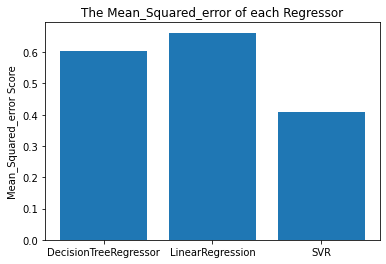

In [63]:
# visualize MSE
labels = ['DecisionTreeRegressor','LinearRegression','SVR']
regressors_mse = [mse_decision_tree,mse_linear_regression,mse_svm_regressor]
plot_accuracy(regressors_mse,labels,'mse')

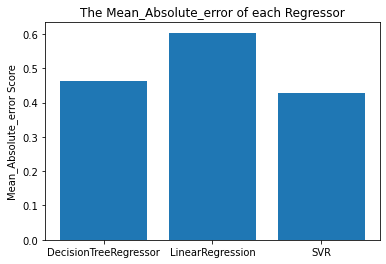

In [64]:
# visualize MAE
labels = ['DecisionTreeRegressor','LinearRegression','SVR']
regressors_mse = [mae_decision_tree,mae_linear_regression,mae_svm_regressor]
plot_accuracy(regressors_mse,labels,'mae')

## From Visualization we see that SVR has the **Lowest** **Mean_Squared_error** and **Mean_Absolute_error** so it the **The Best Model**

## Perofrmance of the Model is, Mean_Squared_error = 0.4081423003530311 and Mean_Absolute_error = 0.42799975229676457